## Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import nltk
from collections import defaultdict
import math
from sklearn.model_selection import StratifiedKFold

In [2]:
# Recogemos	los datos de la base de datos
df_clean = pd.read_csv('../data/train_clean.csv')

## Ponderación con Naive Bayes

In [3]:
# Tokenizamos el texto
df_clean_tokens = pd.DataFrame()
df_clean_tokens['text'] = df_clean['text'].apply(nltk.word_tokenize)
df_clean_tokens['label'] = df_clean['label']

In [4]:
def entrenar_naive_bayes(df_train):
	frecuencias_true = defaultdict(int)
	frecuencias_fake = defaultdict(int)

	for index, noticia in df_train.iterrows():
		es_verdadera = noticia['label'] == 0
		palabras = set(noticia['text'])  # Utilizamos un conjunto para evitar contar varias veces la misma palabra en una noticia
		
		for palabra in palabras:
			if es_verdadera:
				frecuencias_true[palabra] += 1
			else:
				frecuencias_fake[palabra] += 1

	# Crear un DataFrame con las frecuencias de palabras en noticias verdaderas
	df_true = pd.DataFrame({'Palabra': list(frecuencias_true.keys()), 'Frecuencia_true': list(frecuencias_true.values())})

	# Crear un DataFrame con las frecuencias de palabras en noticias falsas
	df_fake = pd.DataFrame({'Palabra': list(frecuencias_fake.keys()), 'Frecuencia_fake': list(frecuencias_fake.values())})

	# Combinar los DataFrames por la columna 'Palabra'
	df_frecs = pd.merge(df_true, df_fake, on='Palabra', how='outer').fillna(0)
 
	# Noticias de cada tipo
	n_true = len(df_train[df_train['label'] == 0])
	n_fake = len(df_train[df_train['label'] == 1])

	# Calculamos las probabilidades de si una noticia es verdadera o falsa
	prob_true = n_true / (n_true + n_fake)
	prob_fake = n_fake / (n_true + n_fake)
 
	# Crear un diccionario para almacenar las probabilidades condicionales de cada palabra
	p_word_given_true = {}
	p_word_given_fake = {}

	# Calcular las probabilidades condicionales de cada palabra
	for word in df_frecs['Palabra']:
		# Calcular la frecuencia de la palabra en noticias verdaderas y falsas
		freq_true = frecuencias_true.get(word, 0)
		freq_fake = frecuencias_fake.get(word, 0)

		# Calcular la probabilidad condicional de que la palabra aparezca en una noticia verdadera o falsa
		p_word_given_true[word] = (freq_true + 1) / (n_true + 2)  # Laplace smoothing
		p_word_given_fake[word] = (freq_fake + 1) / (n_fake + 2)  # Laplace smoothing
  
	return p_word_given_true, p_word_given_fake, prob_true, prob_fake

In [9]:
def prediccion(conjunto_test, diccionario_true, diccionario_fake, probabilidad_true, probabilidad_fake, alpha=1):
    predicciones = []
    for index, noticia in conjunto_test.iterrows():
        # Inicializar las probabilidades de que la noticia sea verdadera o falsa
        p_news_given_true = math.log(probabilidad_true)
        p_news_given_fake = math.log(probabilidad_fake)

        words = set(noticia['text'])
        
        # Calcular la probabilidad de la noticia dado que sea verdadera
        for word in words:
            if word in diccionario_true:
                p_news_given_true += math.log(diccionario_true[word])
            else:
                print('alo')
                p_news_given_true += math.log(alpha) - math.log(len(diccionario_true) + alpha)

        # Calcular la probabilidad de la noticia dado que sea falsa
        for word in words:
            if word in diccionario_fake:
                p_news_given_fake += math.log(diccionario_fake[word])
            else:
                p_news_given_true += math.log(alpha) - math.log(len(diccionario_true) + alpha)

        # Comparar las probabilidades y clasificar la noticia
        if p_news_given_true > p_news_given_fake:
            predicciones.append(0)
        else:
            predicciones.append(1)
    return predicciones

In [6]:
def metricas(y_test, predicciones):
    # Matriz de confusión
	cm = confusion_matrix(y_test, predicciones)
	cm

	# Extraer los valores de la matriz de confusión
	tp, fn, fp, tn = cm.ravel()

	# Mostramos tp, fp, fn, tn
	print("TP: {}".format(tp))
	print("FP: {}".format(fp))
	print("FN: {}".format(fn))
	print("TN: {}".format(tn))

	# Calcular las métricas
	tpr = tp / (tp + fn)  # Tasa de verdaderos positivos (Recall)
	tnr = tn / (tn + fp)  # Tasa de verdaderos negativos
	fpr = fp / (fp + tn)  # Tasa de falsos positivos
	fnr = fn / (fn + tp)  # Tasa de falsos negativos

	# Imprimir las métricas
	print("TPR (Recall): {:.2f}".format(tpr))
	print("TNR: {:.2f}".format(tnr))
	print("FPR: {:.2f}".format(fpr))
	print("FNR: {:.2f}".format(fnr))

	# Comparar las predicciones con las etiquetas verdaderas
	accuracy = accuracy_score(y_test, predicciones)
	precision = precision_score(y_test, predicciones, pos_label=0)
	recall = recall_score(y_test, predicciones, pos_label=0)
	f1 = f1_score(y_test, predicciones, pos_label=0)
 	
  	# Calcular la curva ROC
	fpr, tpr, thresholds = roc_curve(y_test, predicciones)
	
	roc_auc = auc(fpr, tpr)

	# Imprimir las métricas de evaluación
	print("Exactitud ((tp + tn) / (tp + tn+fp+ fn)): {:.2f}".format(accuracy))
	print("Precisión (tp / (tp + fp)): {:.2f}".format(precision))
	print("Recall (tp / (tp + fn)): {:.2f}".format(recall))
	print("Puntuación F1 (2 * (precision * recall) / (precision + recall)): {:.2f}".format(f1))
	print("AUC: {:.2f}".format(roc_auc))
	
	# Graficar la curva ROC
	plt.figure()
	plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
	plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
	plt.xlabel('Tasa de Falsos Positivos (FPR)')
	plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
	plt.title('Curva ROC')
	plt.legend(loc='lower right')
	plt.show()

alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo
alo


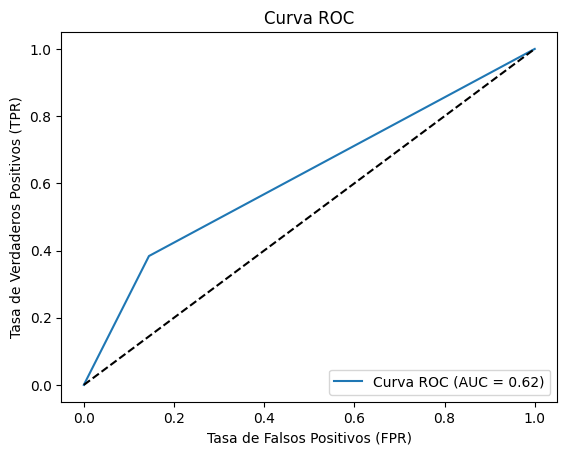

--------------------------------------------------


KeyboardInterrupt: 

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

# Obtener los índices de los conjuntos de entrenamiento y prueba para cada fold
for train_index, test_index in skf.split(df_clean_tokens['text'], df_clean_tokens['label']):
    
    # Obtener los conjuntos de entrenamiento y prueba para el fold actual
    X_train, X_test = df_clean_tokens.iloc[train_index], df_clean_tokens.iloc[test_index]
    y_train, y_test = df_clean_tokens.iloc[train_index]['label'], df_clean_tokens.iloc[test_index]['label']

    p_word_given_true, p_word_given_fake, prob_true, prob_fake = entrenar_naive_bayes(X_train)
    predicciones = prediccion(X_test, p_word_given_true, p_word_given_fake, prob_true, prob_fake)
    metricas(y_test, predicciones)
    print("--------------------------------------------------")